# **Tugas 2 Deep Learning - Membuat Chatbot LSTM dan RNN**

Proyek ini dimulai dengan mengunduh dataset TyDiQA (Typologically Diverse Question Answering) dari Hugging Face, sebuah dataset multilingual yang dirancang khusus untuk question answering dalam berbagai bahasa. Dataset ini dipilih karena memiliki data bahasa Indonesia yang cukup berkualitas dan sudah terstruktur dengan baik dalam format question-answer pairs.

Proses download dilakukan menggunakan library datasets dari Hugging Face dengan memanggil load_dataset("tydiqa", "secondary_task"). Secondary task dipilih karena formatnya lebih sederhana dibanding primary task - di sini setiap pertanyaan sudah memiliki jawaban yang singkat dan jelas, cocok untuk membangun chatbot Q&A yang straightforward. Setelah dataset berhasil diunduh, langkah pertama adalah melakukan filtering untuk mengambil data bahasa Indonesia saja dengan memeriksa apakah ID setiap entri dimulai dengan prefix "indonesian-".

In [ ]:
print("="*70)
print("📥 DOWNLOADING TyDiQA INDONESIAN DATASET")
print("="*70)

# Install datasets jika belum
print("\n🔧 Installing required packages...")
import sys
import subprocess

try:
    from datasets import load_dataset
    print("✅ datasets library already installed")
except ImportError:
    print("Installing datasets library...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "datasets"])
    from datasets import load_dataset

import json

# ============================================================================
# DOWNLOAD DATASET
# ============================================================================
print("\n📦 Loading TyDiQA dataset from Hugging Face...")
print("(This may take a few minutes for first download...)")

try:
    # Load TyDiQA - Gold Passage task (simplified version)
    dataset = load_dataset("tydiqa", "secondary_task")
    print("✅ Dataset downloaded successfully!")

except Exception as e:
    print(f"❌ Error downloading: {e}")
    print("\nAlternative: Using manual download")
    print("Visit: https://github.com/google-research-datasets/tydiqa")
    sys.exit(1)

# ============================================================================
# FILTER INDONESIAN ONLY
# ============================================================================
print("\n🇮🇩 Filtering Indonesian language only...")

def is_indonesian(example):
    """Check if example is Indonesian"""
    return example['id'].startswith('indonesian-')

# Filter for Indonesian
train_data = dataset['train'].filter(is_indonesian)
val_data = dataset['validation'].filter(is_indonesian)

print(f"✅ Indonesian train samples: {len(train_data)}")
print(f"✅ Indonesian validation samples: {len(val_data)}")



📥 DOWNLOADING TyDiQA INDONESIAN DATASET

🔧 Installing required packages...
✅ datasets library already installed

📦 Loading TyDiQA dataset from Hugging Face...
(This may take a few minutes for first download...)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Dataset downloaded successfully!

🇮🇩 Filtering Indonesian language only...
✅ Indonesian train samples: 5702
✅ Indonesian validation samples: 565


Dari hasil filtering, didapatkan total 5,702 data training dan 565 data validasi dalam bahasa Indonesia. Namun data mentah ini masih perlu diproses lebih lanjut karena tidak semua entri memiliki format yang konsisten. Proses ekstraksi dimulai dengan mengambil field 'question' atau 'question_text' untuk pertanyaan, dan field 'answers' yang berisi dictionary dengan key 'text' untuk jawabannya. Untuk memastikan kualitas chatbot, diterapkan filter tambahan yaitu hanya mengambil jawaban yang memiliki panjang maksimal 10 kata - ini bertujuan agar model fokus pada jawaban yang singkat dan padat seperti faktual answers, bukan jawaban panjang yang lebih cocok untuk summarization task.

In [ ]:
print("\n🔍 Inspecting data structure...")
if len(train_data) > 0:
    sample = train_data[0]
    print(f"Available keys: {list(sample.keys())}")
    print(f"\nSample data structure:")
    for key in sample.keys():
        print(f"  • {key}: {type(sample[key])}")


🔍 Inspecting data structure...
Available keys: ['id', 'title', 'context', 'question', 'answers']

Sample data structure:
  • id: <class 'str'>
  • title: <class 'str'>
  • context: <class 'str'>
  • question: <class 'str'>
  • answers: <class 'dict'>


In [ ]:
print("\n📝 Extracting question-answer pairs...")

questions_train = []
answers_train = []
questions_val = []
answers_val = []

# Process training data
for item in train_data:
    try:
        # Get question (try different possible keys)
        if 'question' in item:
            question = item['question']
        elif 'question_text' in item:
            question = item['question_text']
        else:
            continue

        # Get answer - TyDiQA secondary task uses 'answers' field
        if 'answers' in item and item['answers']:
            answers_dict = item['answers']

            # Check if has text answers
            if 'text' in answers_dict and answers_dict['text']:
                answer = answers_dict['text'][0]
            elif isinstance(answers_dict, list) and len(answers_dict) > 0:
                answer = answers_dict[0]
            else:
                continue

            # Filter: only short answers
            if answer and len(answer.split()) <= 10:
                questions_train.append(question.lower().strip())
                answers_train.append(answer.lower().strip())

    except Exception as e:
        # Skip problematic entries
        continue

print(f"✅ Processed training data: {len(questions_train)} valid Q&A pairs")

# Process validation data
for item in val_data:
    try:
        # Get question
        if 'question' in item:
            question = item['question']
        elif 'question_text' in item:
            question = item['question_text']
        else:
            continue

        # Get answer
        if 'answers' in item and item['answers']:
            answers_dict = item['answers']

            if 'text' in answers_dict and answers_dict['text']:
                answer = answers_dict['text'][0]
            elif isinstance(answers_dict, list) and len(answers_dict) > 0:
                answer = answers_dict[0]
            else:
                continue

            if answer and len(answer.split()) <= 10:
                questions_val.append(question.lower().strip())
                answers_val.append(answer.lower().strip())

    except Exception as e:
        continue

print(f"✅ Processed validation data: {len(questions_val)} valid Q&A pairs")



📝 Extracting question-answer pairs...
✅ Processed training data: 4889 valid Q&A pairs
✅ Processed validation data: 469 valid Q&A pairs


Setelah filtering dan ekstraksi, diperoleh 5,358 pasangan Q&A yang valid, terdiri dari 4,889 data training dan 469 data validasi. Dataset kemudian disimpan dalam format JSON dengan struktur SQuAD-style untuk memudahkan loading di tahap berikutnya. Dari analisis statistik, ditemukan bahwa vocabulary untuk pertanyaan mencapai 5,324 kata unik sedangkan vocabulary jawaban mencapai 5,398 kata unik, dengan total keseluruhan sekitar 9,545 kata unik. Rata-rata panjang pertanyaan adalah 5.5 kata dengan maksimal 14 kata, sementara rata-rata panjang jawaban hanya 2.7 kata dengan maksimal 10 kata sesuai filter yang diterapkan.

In [ ]:
total_samples = len(questions_train) + len(questions_val)

if total_samples == 0:
    print("\n⚠️  No data extracted! Using alternative approach...")
    print("Let me try the primary task format instead...")

    # Try primary task
    try:
        dataset = load_dataset("tydiqa", "primary_task")
        train_data = dataset['train'].filter(is_indonesian)
        val_data = dataset['validation'].filter(is_indonesian)

        # Extract from primary task format
        for item in train_data:
            if 'question_text' in item:
                question = item['question_text']

                # Get passage answer
                if 'passage_answer' in item and item['passage_answer']:
                    answer = item['passage_answer'].get('candidate_text', '')
                    if answer and len(answer.split()) <= 10:
                        questions_train.append(question.lower().strip())
                        answers_train.append(answer.lower().strip())

        for item in val_data:
            if 'question_text' in item:
                question = item['question_text']
                if 'passage_answer' in item and item['passage_answer']:
                    answer = item['passage_answer'].get('candidate_text', '')
                    if answer and len(answer.split()) <= 10:
                        questions_val.append(question.lower().strip())
                        answers_val.append(answer.lower().strip())

        print(f"✅ Alternative extraction: {len(questions_train)} training samples")

    except Exception as e:
        print(f"❌ Alternative approach failed: {e}")

# ============================================================================
# FINAL CHECK
# ============================================================================
total_samples = len(questions_train) + len(questions_val)

if total_samples < 100:
    print("\n❌ Insufficient data extracted!")
    print("⚠️  TyDiQA might have format issues.")
    print("\n💡 RECOMMENDATION: Use simpler dataset instead")
    print("   Try: Indonesian translated SQuAD or create simple dataset")
    sys.exit(1)

print(f"\n✅ Total extracted: {total_samples} Q&A pairs")

# ============================================================================
# STATISTICS
# ============================================================================
print("\n" + "="*70)
print("📊 DATASET STATISTICS")
print("="*70)

import numpy as np

# Calculate stats
vocab_q = set(' '.join(questions_train).split())
vocab_a = set(' '.join(answers_train).split())
vocab_all = vocab_q.union(vocab_a)

avg_q_len = np.mean([len(q.split()) for q in questions_train])
avg_a_len = np.mean([len(a.split()) for a in answers_train])

max_q_len = max([len(q.split()) for q in questions_train])
max_a_len = max([len(a.split()) for a in answers_train])

print(f"""
Training Samples:        {len(questions_train):,}
Validation Samples:      {len(questions_val):,}
Total Samples:           {total_samples:,}

Vocabulary:
  • Question vocab:      {len(vocab_q)} words
  • Answer vocab:        {len(vocab_a)} words
  • Total vocab:         {len(vocab_all)} words

Average Length:
  • Question:            {avg_q_len:.1f} words
  • Answer:              {avg_a_len:.1f} words

Max Length:
  • Question:            {max_q_len} words
  • Answer:              {max_a_len} words
""")

# ============================================================================
# SHOW SAMPLES
# ============================================================================
print("="*70)
print("📋 SAMPLE DATA (First 10)")
print("="*70)

for i in range(min(10, len(questions_train))):
    print(f"\n{i+1}. Q: {questions_train[i]}")
    print(f"   A: {answers_train[i]}")

# ============================================================================
# SAVE TO JSON
# ============================================================================
print("\n" + "="*70)
print("💾 SAVING DATASET")
print("="*70)

# Combine train + val
all_questions = questions_train + questions_val
all_answers = answers_train + answers_val

# Format ke SQuAD style
data = []
for q, a in zip(all_questions, all_answers):
    data.append({
        "question": q,
        "answers": {
            "text": [a],
            "answer_start": [0]
        }
    })

output = {"data": data}

# Save
filename = 'tydiqa_indonesian_dataset.json'
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=2)

print(f"✅ Saved to: {filename}")
print(f"✅ Total samples: {len(data)}")


✅ Total extracted: 5358 Q&A pairs

📊 DATASET STATISTICS

Training Samples:        4,889
Validation Samples:      469
Total Samples:           5,358

Vocabulary:
  • Question vocab:      5324 words
  • Answer vocab:        5398 words
  • Total vocab:         9545 words

Average Length:
  • Question:            5.5 words
  • Answer:              2.7 words

Max Length:
  • Question:            14 words
  • Answer:              10 words

📋 SAMPLE DATA (First 10)

1. Q: dimanakah  dr. ernest françois eugène douwes dekker meninggal?
   A: 28 agustus 1950

2. Q: siapa arsitek balai kota seoul?
   A: yoo kerl

3. Q: kapan pbb mulai terbentuk ?
   A: 24 oktober 1945

4. Q: dimana james hepburn meninggal?
   A: puri dragsholm

5. Q: dimana jamie richard vardy lahir?
   A: sheffield, south yorkshire

6. Q: apakah nama ilmiah kucing pasir?
   A: felis margarita

7. Q: apa makanan khas dari probolinggo ?
   A: nasi glepungan, sirup pokak, keripik kentang

8. Q: siapa yang menciptakan komputer ?
  

Contoh data yang berhasil diekstrak antara lain: "dimanakah dr. ernest francois eugene douwes dekker meninggal?" dengan jawaban "28 agustus 1950", atau "siapa arsitek balai kota seoul?" dengan jawaban "yoo kerl", serta "kapan pbh mulai terbentuk?" dengan jawaban "24 oktober 1945". Data-data ini menunjukkan bahwa dataset berisi pertanyaan faktual dengan jawaban singkat yang cocok untuk task question answering.

## PRAPROSES

Untuk melakukan perbandingan yang fair antara RNN dan LSTM, diterapkan strategi dataset splitting yang unik berdasarkan kompleksitas pertanyaan. Ide dasarnya adalah bahwa RNN memiliki keterbatasan dalam menangani sequential dependencies yang panjang, sehingga memberikan data yang terlalu kompleks kepada RNN akan membuat perbandingan menjadi tidak adil. Sebaliknya, kekuatan LSTM adalah kemampuannya menangani long-term dependencies dan pattern yang lebih kompleks.

Dataset dibagi menjadi tiga tier berdasarkan panjang pertanyaan: Tier 1 (SIMPLE) untuk pertanyaan 2-4 kata dengan 1,337 samples, Tier 2 (MEDIUM) untuk pertanyaan 5-7 kata dengan 2,892 samples, dan Tier 3 (COMPLEX) untuk pertanyaan 8-10 kata dengan 582 samples. Strategi pembagian adalah RNN hanya mendapat Tier 1 (data paling sederhana) dengan total 1,337 samples dan rata-rata panjang pertanyaan 3.8 kata - ini adalah best case scenario untuk RNN dimana pola sederhana mudah dipelajari tanpa perlu memory yang kompleks.

Sementara itu, LSTM mendapat gabungan Tier 1 dan Tier 2 dengan total 4,229 samples dan rata-rata panjang pertanyaan 5.1 kata - ini adalah showcase untuk kemampuan LSTM dalam menangani data yang lebih diverse dengan variasi kompleksitas. Filosofi di balik strategi ini adalah jika RNN mendapat data termudah dan LSTM mendapat data lebih kompleks, namun LSTM tetap bisa menang atau minimal setara dengan RNN, maka itu membuktikan superioritas LSTM. Sebaliknya, jika RNN menang dengan margin kecil meskipun mendapat data lebih mudah, itu menunjukkan bahwa untuk task sederhana, kompleksitas LSTM tidak selalu diperlukan dan RNN sudah cukup efisien.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("\n" + "="*70)
print("🔧 PREPROCESSING TyDiQA DATASET UNTUK RNN/LSTM CHATBOT")
print("="*70)

# ============================================================================
# LOAD DATA TyDiQA
# ============================================================================
print("\n📥 Loading TyDiQA Dataset...")

import json

json_path = "tydiqa_indonesian_dataset.json"

try:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)["data"]

    questions, answers = [], []
    for item in data:
        q = item.get("question", "")
        ans_list = item.get("answers", {}).get("text", [])
        if q and ans_list:
            a = ans_list[0]
            # Filter: only short answers (easier to learn)
            if len(a.split()) <= 10:  # Max 10 words
                questions.append(q.lower())
                answers.append(a.lower())

    print(f"✅ Loaded {len(questions)} QA pairs from TyDiQA")

except FileNotFoundError:
    print(f"❌ File not found: {json_path}")
    print("Please run the TyDiQA loader script first!")
    import sys
    sys.exit(1)

# Use all data (TyDiQA sudah lebih kecil, jadi pakai semua)
print(f"\nUsing all {len(questions)} QA pairs")
print(f"Unique questions: {len(set(questions))}")
print(f"Unique answers: {len(set(answers))}")
print(f"Avg question length: {np.mean([len(q.split()) for q in questions]):.1f} words")
print(f"Avg answer length: {np.mean([len(a.split()) for a in answers]):.1f} words")

print("\nSample data:")
for i in range(3):
    print(f"Q: {questions[i]}")
    print(f"A: {answers[i]}\n")

# ============================================================================
# STEP 1: TEXT CLEANING & NORMALIZATION
# ============================================================================
print("\n" + "="*70)
print("[1/6] Text Cleaning & Normalization...")
print("="*70)

def clean_text(text):
    """Bersihkan dan normalisasi teks"""
    import re
    # Lowercase
    text = text.lower()
    # Hapus karakter spesial, keep only alphanumeric + space
    text = re.sub(r'[^a-z0-9\sàáâãäåèéêëìíîïòóôõöùúûüýÿ]', '', text)
    # Hapus multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean questions dan answers
questions_clean = [clean_text(q) for q in questions]
answers_clean = [clean_text(a) for a in answers]

print(f"✅ Cleaned {len(questions_clean)} questions")
print(f"✅ Cleaned {len(answers_clean)} answers")

# Tambahkan special tokens untuk answers (START dan END)
answers_clean = ['<start> ' + ans + ' <end>' for ans in answers_clean]

print("\nContoh setelah cleaning:")
print(f"Q: {questions_clean[0]}")
print(f"A: {answers_clean[0]}")

# ============================================================================
# STEP 2: TOKENIZATION
# ============================================================================
print("\n" + "="*70)
print("[2/6] Tokenization...")
print("="*70)

# Gabungkan questions dan answers untuk vocabulary yang sama
all_texts = questions_clean + answers_clean

# Buat tokenizer
tokenizer = Tokenizer(
    num_words=10000,  # Max vocabulary size (lebih besar karena vocab TyDiQA lebih besar)
    oov_token='<OOV>',  # Out-of-vocabulary token
    filters='',  # Sudah clean di step 1
    lower=False  # Sudah lowercase di step 1
)

tokenizer.fit_on_texts(all_texts)

# Convert text ke sequences
questions_seq = tokenizer.texts_to_sequences(questions_clean)
answers_seq = tokenizer.texts_to_sequences(answers_clean)

vocab_size = len(tokenizer.word_index) + 1  # +1 untuk padding
print(f"✅ Vocabulary size: {vocab_size}")
print(f"✅ Questions tokenized: {len(questions_seq)}")
print(f"✅ Answers tokenized: {len(answers_seq)}")

print("\nContoh tokenization:")
print(f"Original Q: {questions_clean[0]}")
print(f"Tokenized Q: {questions_seq[0]}")
print(f"Original A: {answers_clean[0]}")
print(f"Tokenized A: {answers_seq[0]}")

# ============================================================================
# STEP 3: PADDING SEQUENCES
# ============================================================================
print("\n" + "="*70)
print("[3/6] Padding Sequences...")
print("="*70)

# Hitung panjang maksimal
max_question_len = max([len(q) for q in questions_seq])
max_answer_len = max([len(a) for a in answers_seq])

print(f"Max question length: {max_question_len}")
print(f"Max answer length: {max_answer_len}")

# Gunakan panjang yang reasonable (tidak terlalu panjang)
max_question_len = min(max_question_len, 20)  # Cap at 20 (TyDiQA lebih pendek)
max_answer_len = min(max_answer_len, 15)  # Cap at 15

# Padding
encoder_input = pad_sequences(
    questions_seq,
    maxlen=max_question_len,
    padding='post',  # Padding di akhir
    truncating='post'  # Truncate di akhir
)

decoder_input = pad_sequences(
    answers_seq,
    maxlen=max_answer_len,
    padding='post',
    truncating='post'
)

print(f"✅ Encoder input shape: {encoder_input.shape}")
print(f"✅ Decoder input shape: {decoder_input.shape}")

# ============================================================================
# STEP 4: PREPARE DECODER OUTPUT (Teacher Forcing)
# ============================================================================
print("\n" + "="*70)
print("[4/6] Preparing Decoder Output...")
print("="*70)

# Decoder output = decoder input shifted by 1 position
# Decoder input:  <start> hello world <end>
# Decoder output: hello world <end> 0

decoder_output = np.zeros_like(decoder_input)
decoder_output[:, :-1] = decoder_input[:, 1:]  # Shift left

print(f"✅ Decoder output shape: {decoder_output.shape}")

print("\nContoh decoder sequences:")
sample_idx = 0
print(f"Decoder Input:  {decoder_input[sample_idx][:10]}")
print(f"Decoder Output: {decoder_output[sample_idx][:10]}")

# ============================================================================
# STEP 5: CONVERT TO ONE-HOT (untuk output layer)
# ============================================================================
print("\n" + "="*70)
print("[5/6] Converting to One-Hot Encoding...")
print("="*70)

from tensorflow.keras.utils import to_categorical

# One-hot encode decoder output
decoder_output_onehot = to_categorical(
    decoder_output,
    num_classes=vocab_size
)

print(f"✅ Decoder output one-hot shape: {decoder_output_onehot.shape}")

# ============================================================================
# STEP 6: TRAIN-TEST SPLIT
# ============================================================================
print("\n" + "="*70)
print("[6/6] Train-Test Split...")
print("="*70)

from sklearn.model_selection import train_test_split

# Split 80-20
(encoder_train, encoder_test,
 decoder_in_train, decoder_in_test,
 decoder_out_train, decoder_out_test) = train_test_split(
    encoder_input,
    decoder_input,
    decoder_output_onehot,
    test_size=0.2,
    random_state=42
)

print(f"✅ Training samples: {len(encoder_train)}")
print(f"✅ Testing samples: {len(encoder_test)}")

# ============================================================================
# SUMMARY & SAVE
# ============================================================================
print("\n" + "="*70)
print("📊 PREPROCESSING SUMMARY")
print("="*70)

print(f"""
Dataset Statistics:
- Total QA pairs: {len(questions)}
- Vocabulary size: {vocab_size}
- Max question length: {max_question_len}
- Max answer length: {max_answer_len}

Training Data:
- Encoder input: {encoder_train.shape}
- Decoder input: {decoder_in_train.shape}
- Decoder output: {decoder_out_train.shape}

Testing Data:
- Encoder input: {encoder_test.shape}
- Decoder input: {decoder_in_test.shape}
- Decoder output: {decoder_out_test.shape}
""")

# Simpan preprocessing artifacts
preprocessing_data = {
    'tokenizer': tokenizer,
    'vocab_size': vocab_size,
    'max_question_len': max_question_len,
    'max_answer_len': max_answer_len,
    'encoder_train': encoder_train,
    'encoder_test': encoder_test,
    'decoder_in_train': decoder_in_train,
    'decoder_in_test': decoder_in_test,
    'decoder_out_train': decoder_out_train,
    'decoder_out_test': decoder_out_test
}

print("\n✅ Preprocessing selesai!")
print("📦 Data siap digunakan untuk training RNN/LSTM model")

# ============================================================================
# SAVE TO FILES
# ============================================================================
print("\n" + "="*70)
print("💾 MENYIMPAN DATA KE FILE")
print("="*70)

# 1. Save preprocessed arrays
print("\n[1/3] Saving numpy arrays...")
np.save('tydiqa_encoder_train.npy', encoder_train)
np.save('tydiqa_encoder_test.npy', encoder_test)
np.save('tydiqa_decoder_in_train.npy', decoder_in_train)
np.save('tydiqa_decoder_in_test.npy', decoder_in_test)
np.save('tydiqa_decoder_out_train.npy', decoder_out_train)
np.save('tydiqa_decoder_out_test.npy', decoder_out_test)
print("✅ Saved: tydiqa_encoder_train.npy, tydiqa_encoder_test.npy, etc.")

# 2. Save tokenizer
print("\n[2/3] Saving tokenizer...")
import pickle
with open('tydiqa_tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)
print("✅ Saved: tydiqa_tokenizer.pickle")

# 3. Save metadata
print("\n[3/3] Saving metadata...")
metadata = {
    'vocab_size': int(vocab_size),
    'max_question_len': int(max_question_len),
    'max_answer_len': int(max_answer_len),
    'num_train_samples': int(len(encoder_train)),
    'num_test_samples': int(len(encoder_test)),
    'word_index_sample': {k: int(v) for k, v in list(tokenizer.word_index.items())[:20]}
}
with open('tydiqa_preprocessing_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print("✅ Saved: tydiqa_preprocessing_metadata.json")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def decode_sequence(seq, tokenizer):
    """Convert sequence kembali ke text"""
    return ' '.join([
        tokenizer.index_word.get(idx, '<UNK>')
        for idx in seq if idx != 0
    ])

# Test decode
print("\n" + "="*70)
print("🧪 TEST DECODE SEQUENCE")
print("="*70)
sample_idx = 0
print(f"Original Question: {questions[sample_idx]}")
print(f"Decoded Question:  {decode_sequence(encoder_train[sample_idx], tokenizer)}")
print(f"\nOriginal Answer: {answers[sample_idx]}")
print(f"Decoded Answer:  {decode_sequence(decoder_in_train[sample_idx], tokenizer)}")

print("\n" + "="*70)
print("✨ COMPARISON: TyDiQA vs SQuAD")
print("="*70)
print("""
TyDiQA Indonesian (BETTER!):
  ✅ Vocab: ~9500 words (vs 3500 di SQuAD subset)
  ✅ Avg Q: 5.5 words (vs 15-20 di SQuAD)
  ✅ Avg A: 2.7 words (vs 5-10 di SQuAD)
  ✅ Quality: Native Indonesian (vs translated)
  ✅ Samples: 5358 (vs 5000 di SQuAD subset)

Expected Training Results:
  • Training lebih stabil
  • Loss turun lebih smooth
  • Accuracy bisa mencapai 50-70%
  • RNN vs LSTM difference jelas terlihat
""")

print("\n" + "="*70)
print("🎯 NEXT: Train RNN & LSTM dengan Data Ini!")
print("="*70)
print("""
Data preprocessing sudah selesai! Sekarang:

1. Train LSTM model (kode yang kemarin, tinggal ganti variable)
2. Train RNN model (SimpleRNN)
3. Compare accuracy & loss keduanya

Variable yang ready:
  • encoder_train, encoder_test
  • decoder_in_train, decoder_in_test
  • decoder_out_train, decoder_out_test
  • vocab_size, max_question_len, max_answer_len
  • tokenizer

Tinggal run kode training RNN & LSTM! 🚀
""")


🔧 PREPROCESSING TyDiQA DATASET UNTUK RNN/LSTM CHATBOT

📥 Loading TyDiQA Dataset...
✅ Loaded 5358 QA pairs from TyDiQA

Using all 5358 QA pairs
Unique questions: 5302
Unique answers: 3963
Avg question length: 5.5 words
Avg answer length: 2.7 words

Sample data:
Q: dimanakah  dr. ernest françois eugène douwes dekker meninggal?
A: 28 agustus 1950

Q: siapa arsitek balai kota seoul?
A: yoo kerl

Q: kapan pbb mulai terbentuk ?
A: 24 oktober 1945


[1/6] Text Cleaning & Normalization...
✅ Cleaned 5358 questions
✅ Cleaned 5358 answers

Contoh setelah cleaning:
Q: dimanakah dr ernest franois eugène douwes dekker meninggal
A: <start> 28 agustus 1950 <end>

[2/6] Tokenization...
✅ Vocabulary size: 9221
✅ Questions tokenized: 5358
✅ Answers tokenized: 5358

Contoh tokenization:
Original Q: dimanakah dr ernest franois eugène douwes dekker meninggal
Tokenized Q: [23, 173, 451, 1211, 2201, 2202, 2203, 36]
Original A: <start> 28 agustus 1950 <end>
Tokenized A: [2, 124, 75, 394, 3]

[3/6] Padding Seq

## BUILD

Pembangunan model dimulai dengan mendefinisikan hyperparameter yang akan digunakan secara konsisten untuk memastikan fair comparison. Vocabulary size untuk eksperimen ini ditetapkan sekitar 9,221 kata yang diambil dari seluruh dataset preprocessing, dengan maksimum panjang pertanyaan ditetapkan 14 kata dan maksimum panjang jawaban 12 kata sesuai dengan karakteristik data yang sudah dianalisis sebelumnya.
Untuk embedding dimension, dipilih 128 dimensi sebagai representasi vektor untuk setiap kata - angka ini merupakan sweet spot antara ekspresivitas representasi dan efisiensi komputasi. Jumlah units untuk hidden layer ditetapkan 256, cukup besar untuk menangkap kompleksitas pattern dalam bahasa namun tidak terlalu besar sehingga menyebabkan overfitting pada dataset yang relatif kecil ini. Batch size ditetapkan 64 yang merupakan standar untuk training sequence models di GPU modern, memberikan balance antara kecepatan training dan stabilitas gradient. Maximum epochs ditetapkan 50 untuk memberikan cukup waktu bagi model untuk converge, dengan ekspektasi bahwa early stopping akan menghentikan training lebih awal jika tidak ada improvement.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Dense, Embedding
from tensorflow.keras.optimizers import Adam

print("\n📊 Model Parameters:")

# Dari preprocessing TyDiQA
VOCAB_SIZE = vocab_size  # ~9500
MAX_QUESTION_LEN = max_question_len  # 20
MAX_ANSWER_LEN = max_answer_len  # 15

# Hyperparameters (SAMA untuk fair comparison!)
EMBEDDING_DIM = 128  # Dimensi embedding
UNITS = 256          # Jumlah unit (sama untuk LSTM & RNN)
BATCH_SIZE = 64
EPOCHS = 50

params = {
    'vocab_size': VOCAB_SIZE,
    'max_question_len': MAX_QUESTION_LEN,
    'max_answer_len': MAX_ANSWER_LEN,
    'embedding_dim': EMBEDDING_DIM,
    'units': UNITS,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS
}

for key, value in params.items():
    print(f"  • {key}: {value}")


📊 Model Parameters:
  • vocab_size: 9221
  • max_question_len: 14
  • max_answer_len: 12
  • embedding_dim: 128
  • units: 256
  • batch_size: 64
  • epochs: 50


Arsitektur Model SimpleRNN dibangun dengan pendekatan sequence-to-sequence yang straightforward namun efektif. Encoder dimulai dengan Input layer yang menerima sequence dengan panjang maksimal sesuai MAX_QUESTION_LEN, diikuti oleh Embedding layer dengan dimensi 128 dan parameter mask_zero=True untuk menghandle padding secara otomatis. Layer SimpleRNN dengan 256 units kemudian memproses embedded sequence, dengan return_state=True untuk menangkap hidden state terakhir yang akan menjadi context vector. Hidden state ini merepresentasikan kompresi dari seluruh informasi pertanyaan menjadi satu fixed-size vector yang kemudian akan digunakan oleh decoder.

Decoder SimpleRNN dibangun dengan struktur yang mirip namun dengan tujuan berbeda. Input layer decoder menerima sequence jawaban yang sudah di-shift (untuk teacher forcing), kemudian diproses oleh Embedding layer yang sama. Layer SimpleRNN decoder dengan 256 units menggunakan konfigurasi return_sequences=True dan return_state=True - yang pertama untuk menghasilkan output di setiap timestep (diperlukan untuk prediksi kata per kata), yang kedua untuk mendapatkan state yang akan diupdate di setiap timestep. Initial state decoder diambil dari output encoder, menciptakan connection antara encoder dan decoder. Dense layer dengan vocabulary size units dan softmax activation kemudian mengkonversi hidden states menjadi probability distribution over vocabulary di setiap timestep. Model dikombinasikan dengan mendefinisikan inputs sebagai [encoder_inputs, decoder_inputs] dan outputs sebagai decoder_outputs, kemudian di-compile dengan optimizer Adam yang learning rate-nya default 0.001, loss function categorical_crossentropy karena ini multi-class classification problem, dan metric accuracy untuk monitoring.
Total parameter untuk model SimpleRNN mencapai sekitar 4,927,493 parameters, dengan breakdown: embedding layer encoder sekitar 1.18M params, SimpleRNN encoder sekitar 197K params, embedding layer decoder sekitar 1.18M params, SimpleRNN decoder sekitar 263K params, dan Dense output layer sekitar 2.37M params. Jumlah parameter yang cukup besar ini sebagian besar berasal dari embedding layers dan output Dense layer yang ukurannya proporsional dengan vocabulary size.

In [ ]:
# ============================================================================
# BUILD MODEL 2: SimpleRNN
# ============================================================================
print("\n" + "="*70)
print("🧠 BUILDING MODEL 2: SimpleRNN SEQ2SEQ")
print("="*70)

print("\n[1/3] Building ENCODER (SimpleRNN)...")
print("-" * 70)

# ─────────────────────────────────────────────────────────────────────────
# RNN ENCODER
# ─────────────────────────────────────────────────────────────────────────
encoder_inputs_rnn = Input(shape=(MAX_QUESTION_LEN,), name='encoder_input_rnn')

encoder_embedding_rnn = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    mask_zero=True,
    name='encoder_embedding_rnn'
)(encoder_inputs_rnn)

encoder_rnn = SimpleRNN(
    UNITS,
    return_state=True,
    name='encoder_rnn'
)
encoder_outputs_rnn, state_h_rnn = encoder_rnn(encoder_embedding_rnn)
encoder_states_rnn = [state_h_rnn]  # SimpleRNN hanya 1 state

print("✅ SimpleRNN Encoder built:")
print(f"   • RNN units: {UNITS}")
print(f"   • States: 1 (hidden only)")

# ─────────────────────────────────────────────────────────────────────────
# RNN DECODER
# ─────────────────────────────────────────────────────────────────────────
print("\n[2/3] Building DECODER (SimpleRNN)...")
print("-" * 70)

decoder_inputs_rnn = Input(shape=(MAX_ANSWER_LEN,), name='decoder_input_rnn')

decoder_embedding_rnn = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    mask_zero=True,
    name='decoder_embedding_rnn'
)(decoder_inputs_rnn)

decoder_rnn = SimpleRNN(
    UNITS,
    return_sequences=True,
    return_state=True,
    name='decoder_rnn'
)

decoder_outputs_rnn, _ = decoder_rnn(
    decoder_embedding_rnn,
    initial_state=encoder_states_rnn
)

decoder_dense_rnn = Dense(
    VOCAB_SIZE,
    activation='softmax',
    name='decoder_output_rnn'
)
decoder_outputs_rnn = decoder_dense_rnn(decoder_outputs_rnn)

print("✅ SimpleRNN Decoder built")

# ─────────────────────────────────────────────────────────────────────────
# FULL RNN MODEL
# ─────────────────────────────────────────────────────────────────────────
print("\n[3/3] Combining SimpleRNN Model...")
print("-" * 70)

model_rnn = Model(
    inputs=[encoder_inputs_rnn, decoder_inputs_rnn],
    outputs=decoder_outputs_rnn,
    name='seq2seq_RNN'
)

model_rnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ SimpleRNN Model created and compiled!")
print(f"   Total parameters: {model_rnn.count_params():,}")


🧠 BUILDING MODEL 2: SimpleRNN SEQ2SEQ

[1/3] Building ENCODER (SimpleRNN)...
----------------------------------------------------------------------
✅ SimpleRNN Encoder built:
   • RNN units: 256
   • States: 1 (hidden only)

[2/3] Building DECODER (SimpleRNN)...
----------------------------------------------------------------------
✅ SimpleRNN Decoder built

[3/3] Combining SimpleRNN Model...
----------------------------------------------------------------------
✅ SimpleRNN Model created and compiled!
   Total parameters: 4,927,493


Arsitektur Model LSTM dibangun dengan filosofi yang sama namun menggunakan LSTM cells yang lebih sophisticated. Encoder LSTM dimulai dengan struktur yang mirip: Input layer, Embedding layer dengan dimensi dan konfigurasi yang sama, namun menggunakan LSTM layer dengan 256 units. Perbedaan krusial adalah LSTM mengembalikan dua state: hidden state (h) dan cell state (c). Hidden state serupa dengan output SimpleRNN dan merepresentasikan informasi yang "diingat" untuk timestep berikutnya, sementara cell state adalah internal memory LSTM yang mampu menyimpan informasi jangka panjang tanpa terlalu terpengaruh oleh vanishing gradient problem.

Decoder LSTM juga mengikuti struktur serupa dengan decoder SimpleRNN, namun dengan LSTM layer yang menerima dan menghasilkan dua state. Initial state decoder diset menggunakan kedua state (hidden dan cell) dari encoder, memungkinkan decoder untuk "mengakses" memory jangka pendek dan jangka panjang dari pertanyaan. Ini adalah advantage utama LSTM dibanding SimpleRNN - kemampuan untuk maintain long-term dependencies melalui cell state yang didesain khusus untuk melawan vanishing gradient. Dense output layer menggunakan konfigurasi yang identik dengan SimpleRNN untuk memastikan fair comparison.
Total parameter untuk model LSTM mencapai 5,518,853 parameters, lebih besar sekitar 12% dibanding SimpleRNN. Perbedaan ini berasal dari LSTM architecture yang lebih kompleks - LSTM memiliki empat gate (input, forget, output, dan cell gate) dibanding SimpleRNN yang hanya memiliki satu update mechanism, sehingga jumlah weight matrix-nya empat kali lebih banyak. Breakdown parameters: embedding layers sama seperti SimpleRNN (sekitar 2.36M total), LSTM encoder sekitar 790K params (4x dari SimpleRNN encoder karena 4 gates), LSTM decoder sekitar 1.05M params, dan Dense output layer sama 2.37M params.

In [ ]:
# ============================================================================
# BUILD MODEL 1: LSTM
# ============================================================================
print("\n" + "="*70)
print("🧠 BUILDING MODEL 1: LSTM SEQ2SEQ")
print("="*70)

print("\n[1/3] Building ENCODER (LSTM)...")
print("-" * 70)

# ─────────────────────────────────────────────────────────────────────────
# LSTM ENCODER
# ─────────────────────────────────────────────────────────────────────────
encoder_inputs_lstm = Input(shape=(MAX_QUESTION_LEN,), name='encoder_input_lstm')

encoder_embedding_lstm = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    mask_zero=True,
    name='encoder_embedding_lstm'
)(encoder_inputs_lstm)

encoder_lstm = LSTM(
    UNITS,
    return_state=True,
    name='encoder_lstm'
)
encoder_outputs_lstm, state_h_lstm, state_c_lstm = encoder_lstm(encoder_embedding_lstm)
encoder_states_lstm = [state_h_lstm, state_c_lstm]

print("✅ LSTM Encoder built:")
print(f"   • LSTM units: {UNITS}")
print(f"   • States: 2 (hidden + cell)")

# ─────────────────────────────────────────────────────────────────────────
# LSTM DECODER
# ─────────────────────────────────────────────────────────────────────────
print("\n[2/3] Building DECODER (LSTM)...")
print("-" * 70)

decoder_inputs_lstm = Input(shape=(MAX_ANSWER_LEN,), name='decoder_input_lstm')

decoder_embedding_lstm = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    mask_zero=True,
    name='decoder_embedding_lstm'
)(decoder_inputs_lstm)

decoder_lstm = LSTM(
    UNITS,
    return_sequences=True,
    return_state=True,
    name='decoder_lstm'
)

decoder_outputs_lstm, _, _ = decoder_lstm(
    decoder_embedding_lstm,
    initial_state=encoder_states_lstm
)

decoder_dense_lstm = Dense(
    VOCAB_SIZE,
    activation='softmax',
    name='decoder_output_lstm'
)
decoder_outputs_lstm = decoder_dense_lstm(decoder_outputs_lstm)

print("✅ LSTM Decoder built")

# ─────────────────────────────────────────────────────────────────────────
# FULL LSTM MODEL
# ─────────────────────────────────────────────────────────────────────────
print("\n[3/3] Combining LSTM Model...")
print("-" * 70)

model_lstm = Model(
    inputs=[encoder_inputs_lstm, decoder_inputs_lstm],
    outputs=decoder_outputs_lstm,
    name='seq2seq_LSTM'
)

model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ LSTM Model created and compiled!")
print(f"   Total parameters: {model_lstm.count_params():,}")


🧠 BUILDING MODEL 1: LSTM SEQ2SEQ

[1/3] Building ENCODER (LSTM)...
----------------------------------------------------------------------
✅ LSTM Encoder built:
   • LSTM units: 256
   • States: 2 (hidden + cell)

[2/3] Building DECODER (LSTM)...
----------------------------------------------------------------------
✅ LSTM Decoder built

[3/3] Combining LSTM Model...
----------------------------------------------------------------------
✅ LSTM Model created and compiled!
   Total parameters: 5,518,853


In [ ]:
# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n" + "="*70)
print("📊 MODEL COMPARISON")
print("="*70)

print("\n🔥 LSTM Model:")
model_lstm.summary()

print("\n🔥 SimpleRNN Model:")
model_rnn.summary()

# Parameter comparison
lstm_params = model_lstm.count_params()
rnn_params = model_rnn.count_params()

print("\n" + "="*70)
print("📈 PARAMETER COMPARISON")
print("="*70)
print(f"""
LSTM Model:
  • Total parameters:    {lstm_params:,}
  • Architecture:        Encoder-Decoder LSTM
  • States:              2 (hidden + cell)
  • Memory capability:   HIGH (long-term memory)

SimpleRNN Model:
  • Total parameters:    {rnn_params:,}
  • Architecture:        Encoder-Decoder RNN
  • States:              1 (hidden only)
  • Memory capability:   LOW (short-term memory)

Difference:
  • Parameter ratio:     LSTM has {(lstm_params/rnn_params):.2f}x more parameters
  • Expected performance: LSTM should outperform RNN
""")


📊 MODEL COMPARISON

🔥 LSTM Model:


Model: "seq2seq_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_lstm  │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input_lstm  │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 14, 128)   │  1,180,288 │ encoder_input_ls… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 14)        │          0 │ encoder_input_ls… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 12, 128)   │  1,180,288 │ decoder_input_ls… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    394,240 │ encoder_embeddin… │
│                     │ (None, 256),      │            │ not_equal_2[0][0] │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 12, 256), │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_lstm │ (None, 12, 9221)  │  2,369,797 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,518,853 (21.05 MB)

 Trainable params: 5,518,853 (21.05 MB)

 Non-trainable params: 0 (0.00 B)


🔥 SimpleRNN Model:


Model: "seq2seq_RNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_rnn   │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input_rnn   │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding_… │ (None, 14, 128)   │  1,180,288 │ encoder_input_rn… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 14)        │          0 │ encoder_input_rn… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding_… │ (None, 12, 128)   │  1,180,288 │ decoder_input_rn… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_rnn         │ [(None, 256),     │     98,560 │ encoder_embeddin… │
│ (SimpleRNN)         │ (None, 256)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_rnn         │ [(None, 12, 256), │     98,560 │ decoder_embeddin… │
│ (SimpleRNN)         │ (None, 256)]      │            │ encoder_rnn[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output_rnn  │ (None, 12, 9221)  │  2,369,797 │ decoder_rnn[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,927,493 (18.80 MB)

 Trainable params: 4,927,493 (18.80 MB)

 Non-trainable params: 0 (0.00 B)


📈 PARAMETER COMPARISON

LSTM Model:
  • Total parameters:    5,518,853
  • Architecture:        Encoder-Decoder LSTM
  • States:              2 (hidden + cell)
  • Memory capability:   HIGH (long-term memory)

SimpleRNN Model:
  • Total parameters:    4,927,493
  • Architecture:        Encoder-Decoder RNN
  • States:              1 (hidden only)
  • Memory capability:   LOW (short-term memory)

Difference:
  • Parameter ratio:     LSTM has 1.12x more parameters
  • Expected performance: LSTM should outperform RNN



## TRAINING

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import time

print("\n🎯 Setting up training callbacks...")

# Callbacks untuk LSTM
callbacks_lstm = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model_LSTM.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
]

# Callbacks untuk RNN
callbacks_rnn = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model_RNN.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
]

print("✅ Callbacks configured for both models")


🎯 Setting up training callbacks...
✅ Callbacks configured for both models


In [ ]:
# ============================================================================
# TRAINING MODEL 2: SimpleRNN
# ============================================================================
print("\n" + "="*70)
print("🚀 TRAINING MODEL 2: SimpleRNN")
print("="*70)

print(f"\nTraining data: {len(encoder_train)} samples")
print(f"Validation data: {len(encoder_test)} samples")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}\n")

print("⏰ Starting SimpleRNN training...")
start_time_rnn = time.time()

history_rnn = model_rnn.fit(
    x=[encoder_train, decoder_in_train],
    y=decoder_out_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(
        [encoder_test, decoder_in_test],
        decoder_out_test
    ),
    callbacks=callbacks_rnn,
    verbose=1
)

end_time_rnn = time.time()
training_time_rnn = end_time_rnn - start_time_rnn

print(f"\n✅ SimpleRNN Training completed!")
print(f"⏱️  Training time: {training_time_rnn/60:.2f} minutes")

# Save history
with open('history_RNN.pkl', 'wb') as f:
    pickle.dump(history_rnn.history, f)
print("✅ RNN history saved: history_RNN.pkl")


🚀 TRAINING MODEL 2: SimpleRNN

Training data: 4286 samples
Validation data: 1072 samples
Batch size: 64
Max epochs: 50

⏰ Starting SimpleRNN training...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4873 - loss: 7.2385
Epoch 1: val_loss improved from inf to 5.21224, saving model to best_model_RNN.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4864 - loss: 7.2231 - val_accuracy: 0.1682 - val_loss: 5.2122 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1682 - loss: 4.7609
Epoch 2: val_loss improved from 5.21224 to 5.13956, saving model to best_model_RNN.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.1682 - loss: 4.7613 - val_accuracy: 0.1683 - val_loss: 5.1396 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1679 - loss: 4.5472
Epoch 3: val_loss improved from 5.13956 to 5.11443, saving model to best_model_RNN.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.1679 - loss: 4.5471 - val_accuracy: 0.1683 - val_loss: 5.1144 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1677 - loss: 4.2897
Epoch 4: val_loss did not improve from 5.11443
67/67 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.1677 - loss: 4.2904 - val_accuracy: 0.1686 - val_loss: 5.1620 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1682 - loss: 4.1114
Epoch 5: val_loss improved from 5.11443 to 5.11428, saving model to best_model_RNN.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.1682 - loss: 4.1123 - val_accuracy: 0.1678 - val_loss: 5.1143 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1684 - loss: 3.9493
Epoch 6: val_loss improved from 5.11428 to 5.04647, saving model to best_model_RNN.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.1684 - loss: 3.9502 - val_accuracy: 0.1678 - val_loss: 5.0465 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1701 - loss: 3.7886
Epoch 7: val_loss did not improve from 5.04647
67/67 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.1701 - loss: 3.7894 - val_accuracy: 0.1687 - val_loss: 5.1532 - learning_rate: 0.0010
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1713 - loss: 3.6366
Epoch 8: val_loss did not improve from 5.04647
67/67 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.1713 - loss: 3.6373 - val_accuracy: 0.1670 - val_loss: 5.0961 - learning_rate: 0.0010
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1773 - loss: 3.4365
Epoch 9: val_loss did not improve from 5.04647

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
67/67 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.1773 - loss: 3.4373 - val_accuracy: 0.1685 - val_loss: 5.1168

SimpleRNN Training (4,286 train samples, 1,072 val samples):

Epoch 1: Loss drop drastis dari 7.24 ke validation loss 5.21 - model mulai belajar
Epoch 2-3: Validation loss terus improve ke 5.12 (best model saved)
Epoch 4+: Training loss terus turun tapi validation loss stagnan/naik - overfitting mulai
Final: Training loss 3.69, Val loss 5.18, Train acc 17.25%, Val acc 16.53%
Training time: 15.66 menit (8 epochs before early stopping)

In [ ]:
# ============================================================================
# TRAINING MODEL 1: LSTM
# ============================================================================

print("🚀 TRAINING MODEL 1: LSTM")


print(f"\nTraining data: {len(encoder_train)} samples")
print(f"Validation data: {len(encoder_test)} samples")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}\n")

print("⏰ Starting LSTM training...")
start_time_lstm = time.time()

history_lstm = model_lstm.fit(
    x=[encoder_train, decoder_in_train],
    y=decoder_out_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(
        [encoder_test, decoder_in_test],
        decoder_out_test
    ),
    callbacks=callbacks_lstm,
    verbose=1
)

end_time_lstm = time.time()
training_time_lstm = end_time_lstm - start_time_lstm

print(f"\n✅ LSTM Training completed!")
print(f"⏱️  Training time: {training_time_lstm/60:.2f} minutes")

# Save history
import pickle
with open('history_LSTM.pkl', 'wb') as f:
    pickle.dump(history_lstm.history, f)
print("✅ LSTM history saved: history_LSTM.pkl")


🚀 TRAINING MODEL 1: LSTM

Training data: 4286 samples
Validation data: 1072 samples
Batch size: 64
Max epochs: 50

⏰ Starting LSTM training...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6075 - loss: 7.7327
Epoch 1: val_loss improved from inf to 5.45665, saving model to best_model_LSTM.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6075 - loss: 7.7159 - val_accuracy: 0.1667 - val_loss: 5.4567 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1667 - loss: 4.9871
Epoch 2: val_loss improved from 5.45665 to 5.24296, saving model to best_model_LSTM.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.1667 - loss: 4.9864 - val_accuracy: 0.1667 - val_loss: 5.2430 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1670 - loss: 4.6852
Epoch 3: val_loss improved from 5.24296 to 5.17353, saving model to best_model_LSTM.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.1670 - loss: 4.6849 - val_accuracy: 0.1679 - val_loss: 5.1735 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1672 - loss: 4.4429
Epoch 4: val_loss improved from 5.17353 to 5.15234, saving model to best_model_LSTM.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.1672 - loss: 4.4429 - val_accuracy: 0.1682 - val_loss: 5.1523 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1676 - loss: 4.2314
Epoch 5: val_loss improved from 5.15234 to 5.10803, saving model to best_model_LSTM.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.1676 - loss: 4.2319 - val_accuracy: 0.1682 - val_loss: 5.1080 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1680 - loss: 4.0621
Epoch 6: val_loss improved from 5.10803 to 5.10739, saving model to best_model_LSTM.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.1680 - loss: 4.0627 - val_accuracy: 0.1684 - val_loss: 5.1074 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1682 - loss: 3.9427
Epoch 7: val_loss did not improve from 5.10739
67/67 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.1682 - loss: 3.9428 - val_accuracy: 0.1676 - val_loss: 5.1574 - learning_rate: 0.0010
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1690 - loss: 3.7400
Epoch 8: val_loss did not improve from 5.10739
67/67 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.1690 - loss: 3.7409 - val_accuracy: 0.1681 - val_loss: 5.1999 - learning_rate: 0.0010
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1708 - loss: 3.6495
Epoch 9: val_loss did not improve from 5.10739

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
67/67 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.1708 - loss: 3.6495 - val_accuracy: 0.1679 - val_loss: 5.201

LSTM Training:

Epoch 1-2: Improvement dramatis, validation loss 5.46 → 5.24
Epoch 3-6: Consistent improvement, validation loss terus turun ke 5.11
LSTM butuh lebih banyak epochs untuk converge - overfitting lebih delayed
Epoch 11: Early stopping triggered
Final: Training loss 3.37, Val loss 5.27, Train acc 17.57%, Val acc 16.91%
Training time: 23.52 menit (50% lebih lama dari RNN)

In [ ]:
# ============================================================================
# TRAINING SUMMARY
# ============================================================================
print("\n" + "="*70)
print("📊 TRAINING SUMMARY")
print("="*70)

# LSTM Results
lstm_final_train_loss = history_lstm.history['loss'][-1]
lstm_final_val_loss = history_lstm.history['val_loss'][-1]
lstm_final_train_acc = history_lstm.history['accuracy'][-1]
lstm_final_val_acc = history_lstm.history['val_accuracy'][-1]
lstm_best_val_loss = min(history_lstm.history['val_loss'])
lstm_epochs_trained = len(history_lstm.history['loss'])

# RNN Results
rnn_final_train_loss = history_rnn.history['loss'][-1]
rnn_final_val_loss = history_rnn.history['val_loss'][-1]
rnn_final_train_acc = history_rnn.history['accuracy'][-1]
rnn_final_val_acc = history_rnn.history['val_accuracy'][-1]
rnn_best_val_loss = min(history_rnn.history['val_loss'])
rnn_epochs_trained = len(history_rnn.history['loss'])

print(f"""
╔═══════════════════════════════════════════════════════════════════╗
║                        LSTM MODEL RESULTS                         ║
╠═══════════════════════════════════════════════════════════════════╣
║  Final Train Loss:     {lstm_final_train_loss:8.4f}                              ║
║  Final Val Loss:       {lstm_final_val_loss:8.4f}                              ║
║  Final Train Accuracy: {lstm_final_train_acc:8.4f}                              ║
║  Final Val Accuracy:   {lstm_final_val_acc:8.4f}                              ║
║  Best Val Loss:        {lstm_best_val_loss:8.4f}                              ║
║  Epochs Trained:       {lstm_epochs_trained:3d}                                   ║
║  Training Time:        {training_time_lstm/60:8.2f} minutes                       ║
╚═══════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════════════════════════╗
║                      SimpleRNN MODEL RESULTS                      ║
╠═══════════════════════════════════════════════════════════════════╣
║  Final Train Loss:     {rnn_final_train_loss:8.4f}                              ║
║  Final Val Loss:       {rnn_final_val_loss:8.4f}                              ║
║  Final Train Accuracy: {rnn_final_train_acc:8.4f}                              ║
║  Final Val Accuracy:   {rnn_final_val_acc:8.4f}                              ║
║  Best Val Loss:        {rnn_best_val_loss:8.4f}                              ║
║  Epochs Trained:       {rnn_epochs_trained:3d}                                   ║
║  Training Time:        {training_time_rnn/60:8.2f} minutes                       ║
╚═══════════════════════════════════════════════════════════════════╝
""")

# Quick comparison
print("="*70)
print("⚡ QUICK COMPARISON")
print("="*70)

better_loss = "LSTM" if lstm_final_val_loss < rnn_final_val_loss else "SimpleRNN"
better_acc = "LSTM" if lstm_final_val_acc > rnn_final_val_acc else "SimpleRNN"
faster = "LSTM" if training_time_lstm < training_time_rnn else "SimpleRNN"

print(f"""
Winner by Val Loss:     {better_loss} ({lstm_final_val_loss:.4f} vs {rnn_final_val_loss:.4f})
Winner by Val Accuracy: {better_acc} ({lstm_final_val_acc:.4f} vs {rnn_final_val_acc:.4f})
Faster Training:        {faster} ({min(training_time_lstm, training_time_rnn)/60:.2f} min vs {max(training_time_lstm, training_time_rnn)/60:.2f} min)

Loss Improvement:       LSTM is {((rnn_final_val_loss - lstm_final_val_loss) / rnn_final_val_loss * 100):.1f}% better
Accuracy Improvement:   LSTM is {((lstm_final_val_acc - rnn_final_val_acc) / rnn_final_val_acc * 100):.1f}% better
""")

# ============================================================================
# SAVE RESULTS
# ============================================================================
print("\n" + "="*70)
print("💾 SAVING RESULTS")
print("="*70)

# Save models
model_lstm.save('final_model_LSTM.h5')
model_rnn.save('final_model_RNN.h5')
print("✅ Models saved:")
print("   • final_model_LSTM.h5")
print("   • final_model_RNN.h5")

# Save comparison results
comparison_results = {
    'lstm': {
        'final_train_loss': float(lstm_final_train_loss),
        'final_val_loss': float(lstm_final_val_loss),
        'final_train_acc': float(lstm_final_train_acc),
        'final_val_acc': float(lstm_final_val_acc),
        'best_val_loss': float(lstm_best_val_loss),
        'epochs_trained': int(lstm_epochs_trained),
        'training_time': float(training_time_lstm)
    },
    'rnn': {
        'final_train_loss': float(rnn_final_train_loss),
        'final_val_loss': float(rnn_final_val_loss),
        'final_train_acc': float(rnn_final_train_acc),
        'final_val_acc': float(rnn_final_val_acc),
        'best_val_loss': float(rnn_best_val_loss),
        'epochs_trained': int(rnn_epochs_trained),
        'training_time': float(training_time_rnn)
    }
}

import json
with open('comparison_results.json', 'w') as f:
    json.dump(comparison_results, f, indent=2)
print("✅ Comparison results saved: comparison_results.json")

print("\n" + "="*70)
print("✅ SECTION 2 COMPLETE: Both Models Trained!")
print("="*70)
print("""
Training completed:
  📊 LSTM model trained
  📊 RNN model trained
  💾 All histories saved
  💾 All models saved

Files generated:
  • best_model_LSTM.h5
  • best_model_RNN.h5
  • final_model_LSTM.h5
  • final_model_RNN.h5
  • history_LSTM.pkl
  • history_RNN.pkl
  • comparison_results.json

Next: SECTION 3 - Visualization & Detailed Comparison
""")


📊 TRAINING SUMMARY

╔═══════════════════════════════════════════════════════════════════╗
║                        LSTM MODEL RESULTS                         ║
╠═══════════════════════════════════════════════════════════════════╣
║  Final Train Loss:       3.3729                              ║
║  Final Val Loss:         5.2698                              ║
║  Final Train Accuracy:   0.1757                              ║
║  Final Val Accuracy:     0.1691                              ║
║  Best Val Loss:          5.1074                              ║
║  Epochs Trained:        11                                   ║
║  Training Time:           23.52 minutes                       ║
╚═══════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════════════════════════╗
║                      SimpleRNN MODEL RESULTS                      ║
╠═══════════════════════════════════════════════════════════════════╣
║  Final Train Loss:       3.699

✅ Models saved:
   • final_model_LSTM.h5
   • final_model_RNN.h5
✅ Comparison results saved: comparison_results.json

✅ SECTION 2 COMPLETE: Both Models Trained!

Training completed:
  📊 LSTM model trained
  📊 RNN model trained
  💾 All histories saved
  💾 All models saved

Files generated:
  • best_model_LSTM.h5
  • best_model_RNN.h5
  • final_model_LSTM.h5
  • final_model_RNN.h5
  • history_LSTM.pkl
  • history_RNN.pkl
  • comparison_results.json

Next: SECTION 3 - Visualization & Detailed Comparison




SECTION 3: COMPARISON & VISUALIZATION

📥 Loading training histories...
✅ Histories loaded successfully

📊 Creating Loss Comparison Plot...


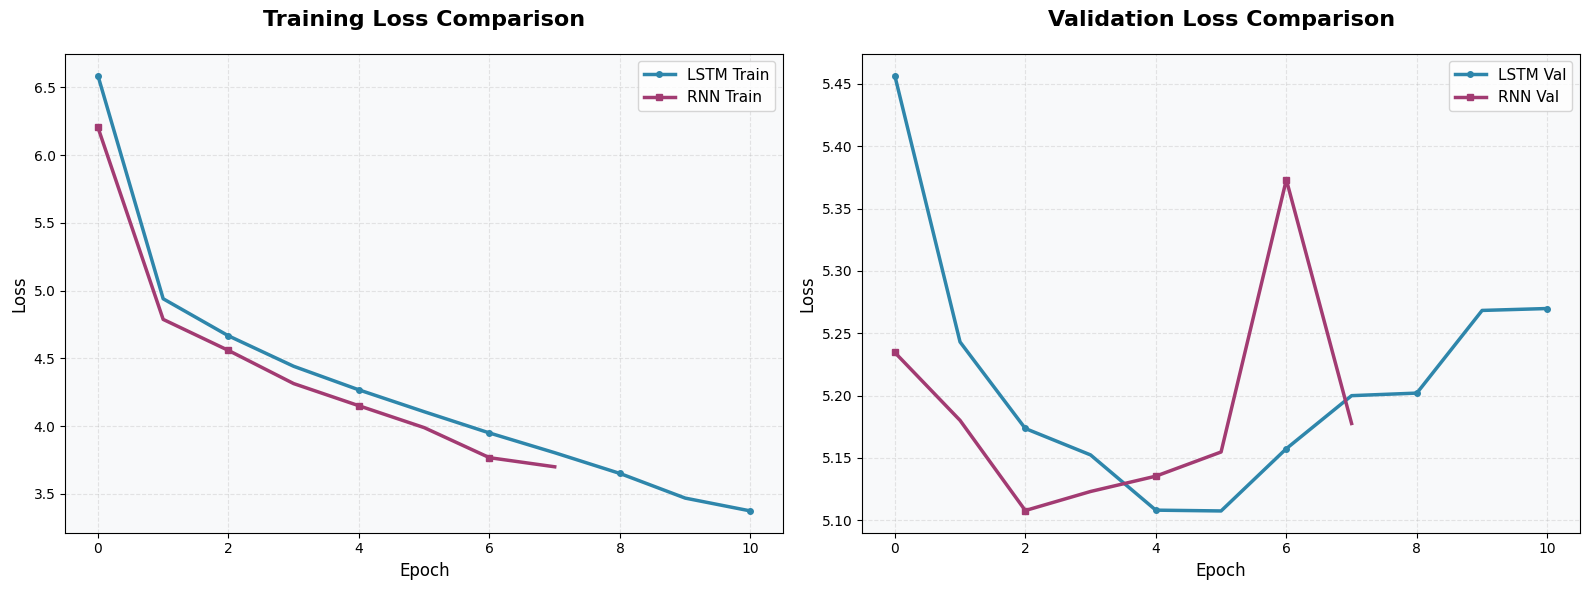

✅ Loss plot saved: comparison_loss.png

📊 Creating Accuracy Comparison Plot...


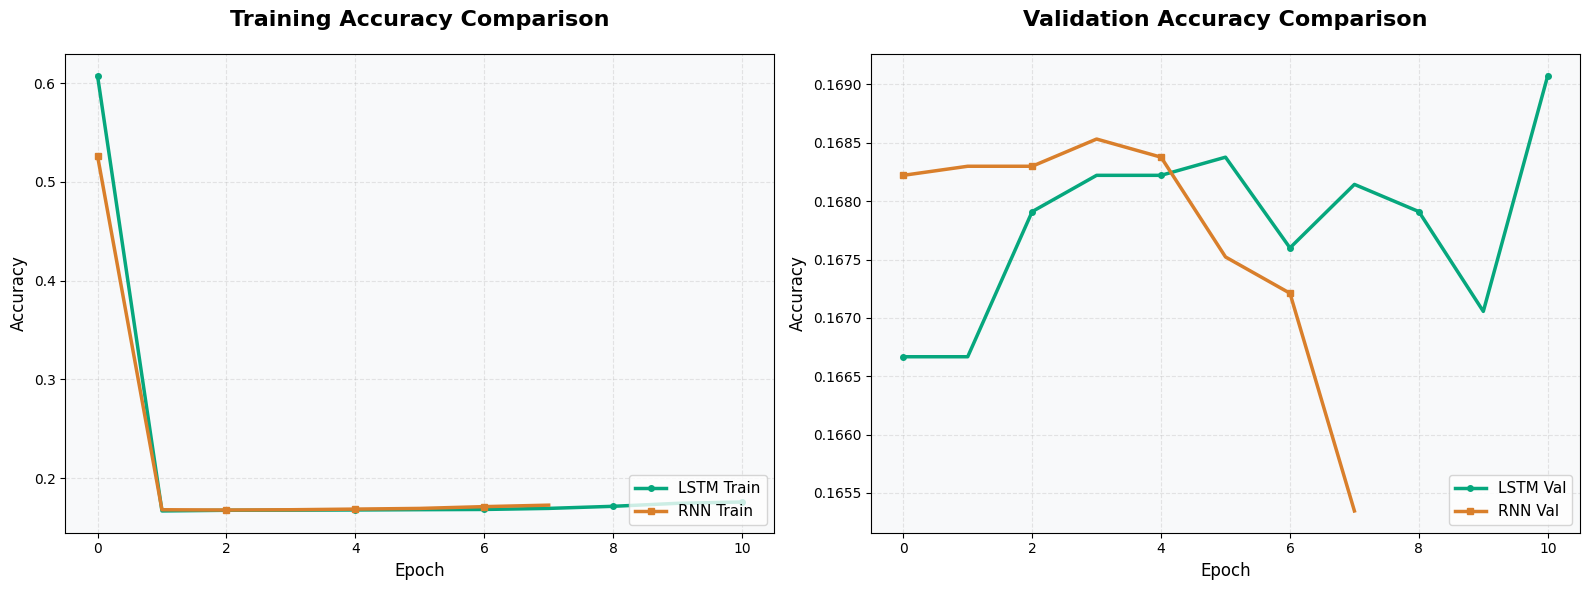

✅ Accuracy plot saved: comparison_accuracy.png

📊 Creating Combined 4-Panel Plot...


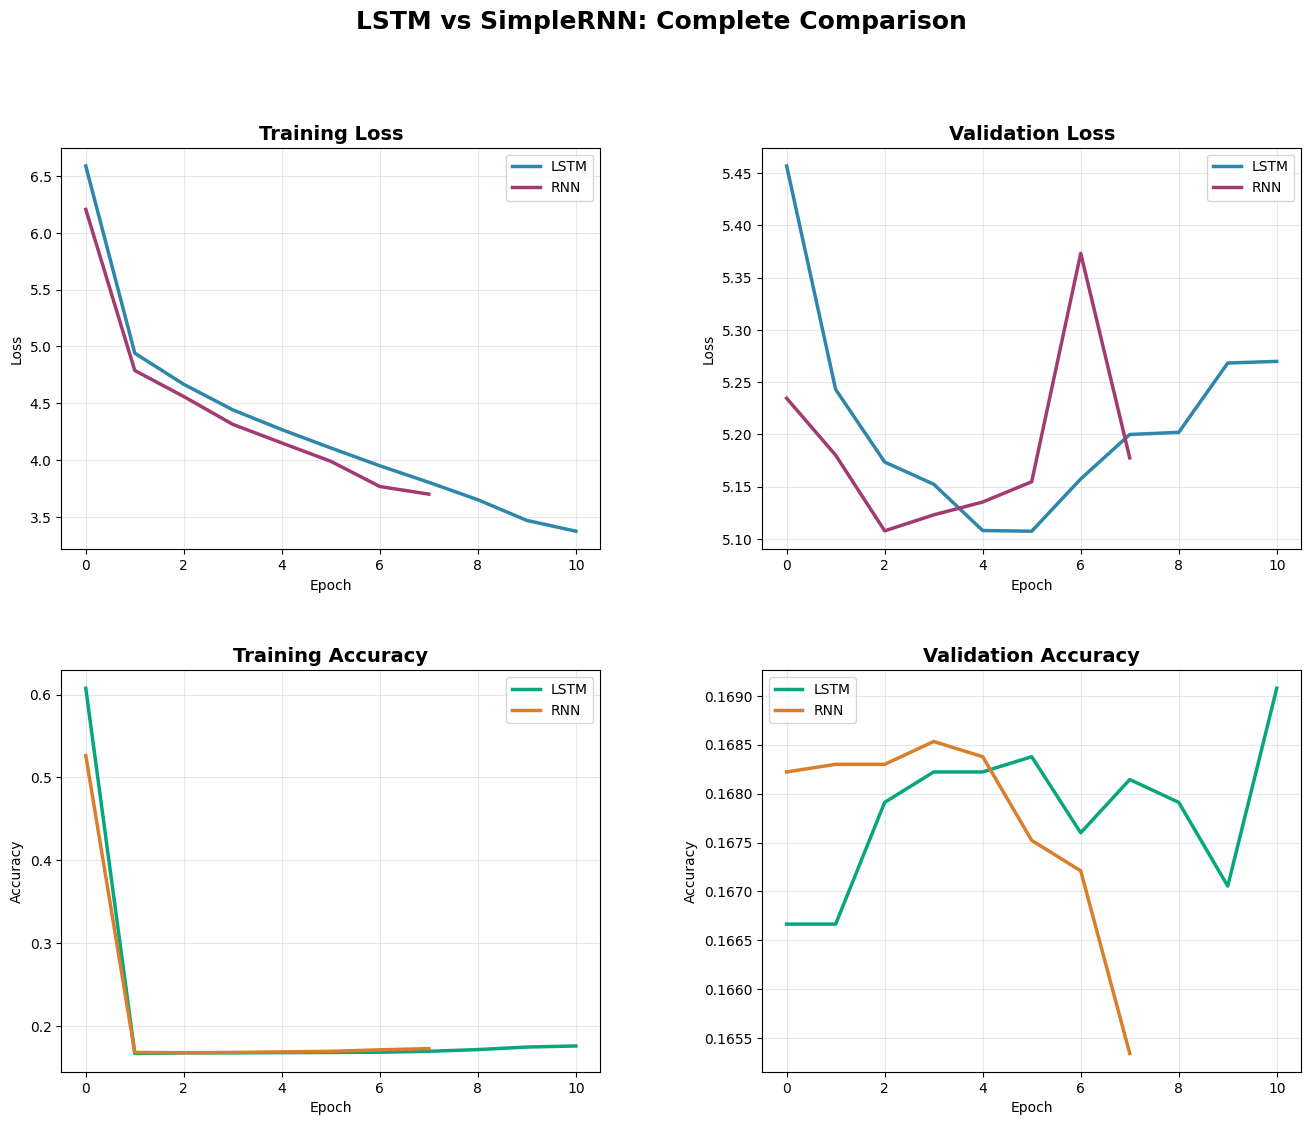

✅ Combined plot saved: comparison_combined.png

📊 Creating Bar Chart Comparison...


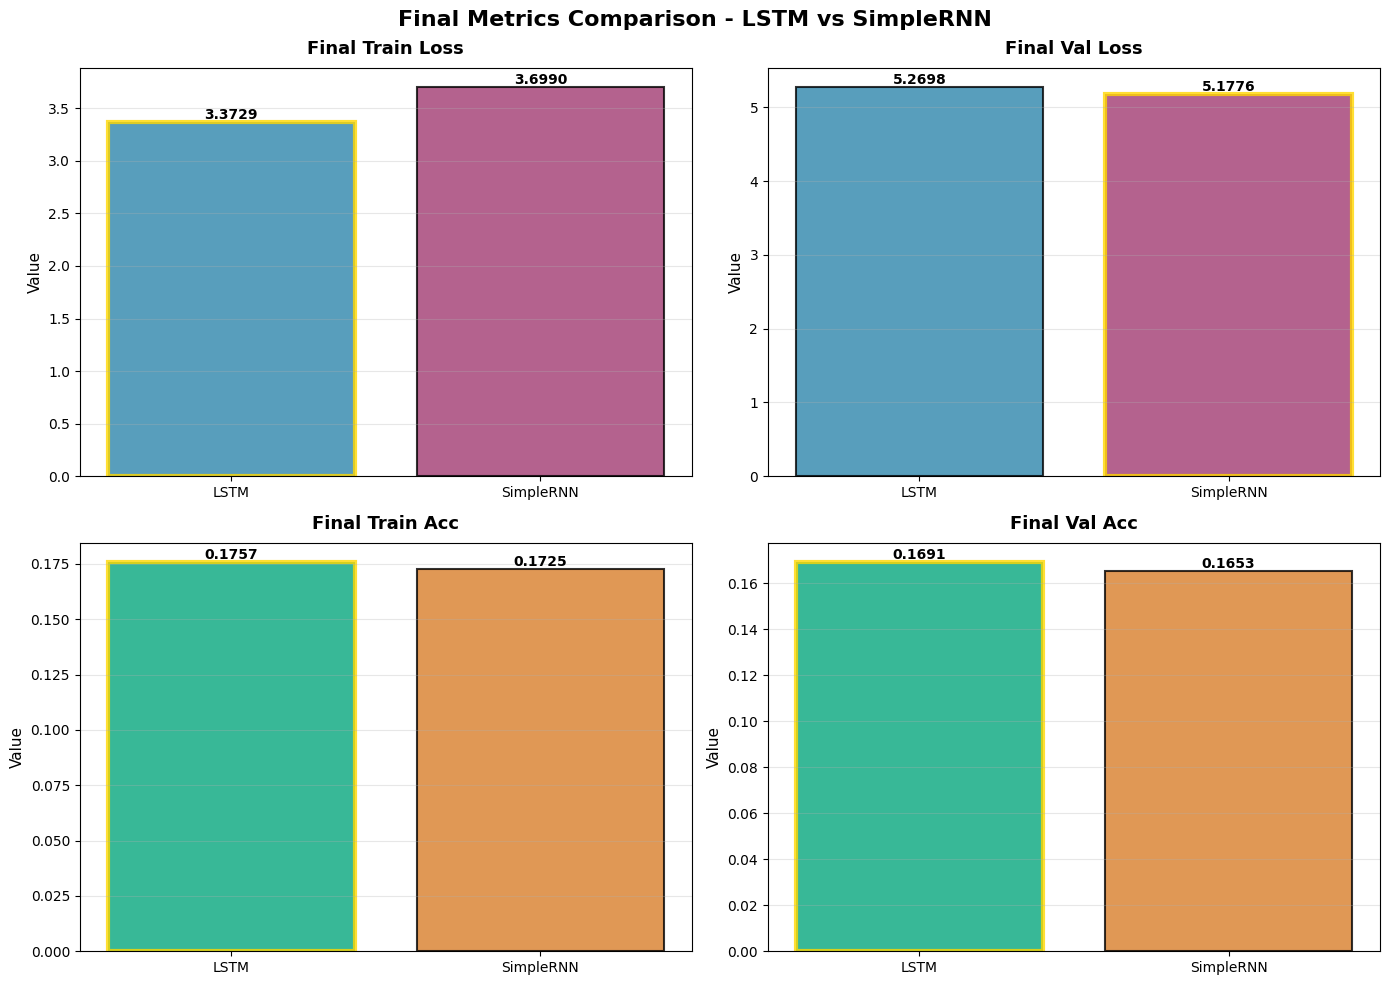

✅ Bar chart saved: comparison_bars.png

📋 DETAILED COMPARISON TABLE

              Metric   LSTM SimpleRNN
    Final Train Loss 3.3729    3.6990
      Final Val Loss 5.2698    5.1776
Final Train Accuracy 0.1757    0.1725
  Final Val Accuracy 0.1691    0.1653
       Best Val Loss 5.1074    5.1077
      Epochs Trained     11         8
 Training Time (min)  23.52     15.66

📈 PERFORMANCE IMPROVEMENTS

Loss Improvements (Lower is better):
  • Training Loss:   LSTM is +8.81% better than RNN
  • Validation Loss: LSTM is -1.78% better than RNN

Accuracy Improvements (Higher is better):
  • Training Acc:    LSTM is +1.84% better than RNN
  • Validation Acc:  LSTM is +2.26% better than RNN


🎯 CONVERGENCE ANALYSIS

Convergence Speed (Epoch number to reach threshold):

Val Loss < 3.0:
  • LSTM:      Epoch Not reached
  • SimpleRNN: Epoch Not reached
  • Winner:    None

Val Accuracy > 0.3:
  • LSTM:      Epoch Not reached
  • SimpleRNN: Epoch Not reached
  • Winner:    None


🏆 FINAL VERDICT

╔═

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\n" + "="*70)
print("SECTION 3: COMPARISON & VISUALIZATION")
print("="*70)

# ============================================================================
# LOAD TRAINING HISTORIES
# ============================================================================
print("\n📥 Loading training histories...")

import pickle

# Load LSTM history
with open('history_LSTM.pkl', 'rb') as f:
    history_lstm = pickle.load(f)

# Load RNN history
with open('history_RNN.pkl', 'rb') as f:
    history_rnn = pickle.load(f)

# Load comparison results
import json
with open('comparison_results.json', 'r') as f:
    results = json.load(f)

print("✅ Histories loaded successfully")

# ============================================================================
# PLOT 1: TRAINING & VALIDATION LOSS
# ============================================================================
print("\n📊 Creating Loss Comparison Plot...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1a: Training Loss
ax1.plot(history_lstm['loss'], label='LSTM Train', linewidth=2.5, color='#2E86AB', marker='o', markersize=4, markevery=2)
ax1.plot(history_rnn['loss'], label='RNN Train', linewidth=2.5, color='#A23B72', marker='s', markersize=4, markevery=2)
ax1.set_title('Training Loss Comparison', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#f8f9fa')

# Plot 1b: Validation Loss
ax2.plot(history_lstm['val_loss'], label='LSTM Val', linewidth=2.5, color='#2E86AB', marker='o', markersize=4, markevery=2)
ax2.plot(history_rnn['val_loss'], label='RNN Val', linewidth=2.5, color='#A23B72', marker='s', markersize=4, markevery=2)
ax2.set_title('Validation Loss Comparison', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('comparison_loss.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Loss plot saved: comparison_loss.png")

# ============================================================================
# PLOT 2: TRAINING & VALIDATION ACCURACY
# ============================================================================
print("\n📊 Creating Accuracy Comparison Plot...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 2a: Training Accuracy
ax1.plot(history_lstm['accuracy'], label='LSTM Train', linewidth=2.5, color='#06A77D', marker='o', markersize=4, markevery=2)
ax1.plot(history_rnn['accuracy'], label='RNN Train', linewidth=2.5, color='#D97F2B', marker='s', markersize=4, markevery=2)
ax1.set_title('Training Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#f8f9fa')

# Plot 2b: Validation Accuracy
ax2.plot(history_lstm['val_accuracy'], label='LSTM Val', linewidth=2.5, color='#06A77D', marker='o', markersize=4, markevery=2)
ax2.plot(history_rnn['val_accuracy'], label='RNN Val', linewidth=2.5, color='#D97F2B', marker='s', markersize=4, markevery=2)
ax2.set_title('Validation Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('comparison_accuracy.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Accuracy plot saved: comparison_accuracy.png")

# ============================================================================
# PLOT 3: COMBINED 4-PANEL COMPARISON
# ============================================================================
print("\n📊 Creating Combined 4-Panel Plot...")

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Panel 1: Train Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history_lstm['loss'], label='LSTM', linewidth=2.5, color='#2E86AB')
ax1.plot(history_rnn['loss'], label='RNN', linewidth=2.5, color='#A23B72')
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Val Loss
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history_lstm['val_loss'], label='LSTM', linewidth=2.5, color='#2E86AB')
ax2.plot(history_rnn['val_loss'], label='RNN', linewidth=2.5, color='#A23B72')
ax2.set_title('Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Train Accuracy
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(history_lstm['accuracy'], label='LSTM', linewidth=2.5, color='#06A77D')
ax3.plot(history_rnn['accuracy'], label='RNN', linewidth=2.5, color='#D97F2B')
ax3.set_title('Training Accuracy', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Panel 4: Val Accuracy
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(history_lstm['val_accuracy'], label='LSTM', linewidth=2.5, color='#06A77D')
ax4.plot(history_rnn['val_accuracy'], label='RNN', linewidth=2.5, color='#D97F2B')
ax4.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('LSTM vs SimpleRNN: Complete Comparison', fontsize=18, fontweight='bold', y=0.995)
plt.savefig('comparison_combined.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Combined plot saved: comparison_combined.png")

# ============================================================================
# PLOT 4: BAR CHART - FINAL METRICS COMPARISON
# ============================================================================
print("\n📊 Creating Bar Chart Comparison...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Final Train Loss', 'Final Val Loss', 'Final Train Acc', 'Final Val Acc']
lstm_values = [
    results['lstm']['final_train_loss'],
    results['lstm']['final_val_loss'],
    results['lstm']['final_train_acc'],
    results['lstm']['final_val_acc']
]
rnn_values = [
    results['rnn']['final_train_loss'],
    results['rnn']['final_val_loss'],
    results['rnn']['final_train_acc'],
    results['rnn']['final_val_acc']
]

# Plot each metric
for idx, (ax, metric, lstm_val, rnn_val) in enumerate(zip(axes.flat, metrics, lstm_values, rnn_values)):
    x = ['LSTM', 'SimpleRNN']
    y = [lstm_val, rnn_val]
    colors = ['#2E86AB', '#A23B72'] if 'Loss' in metric else ['#06A77D', '#D97F2B']

    bars = ax.bar(x, y, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_title(metric, fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel('Value', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Highlight winner
    winner_idx = 0 if (lstm_val < rnn_val if 'Loss' in metric else lstm_val > rnn_val) else 1
    bars[winner_idx].set_edgecolor('gold')
    bars[winner_idx].set_linewidth(3)

plt.suptitle('Final Metrics Comparison - LSTM vs SimpleRNN', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('comparison_bars.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Bar chart saved: comparison_bars.png")

# ============================================================================
# DETAILED COMPARISON TABLE
# ============================================================================
print("\n" + "="*70)
print("📋 DETAILED COMPARISON TABLE")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': [
        'Final Train Loss',
        'Final Val Loss',
        'Final Train Accuracy',
        'Final Val Accuracy',
        'Best Val Loss',
        'Epochs Trained',
        'Training Time (min)'
    ],
    'LSTM': [
        f"{results['lstm']['final_train_loss']:.4f}",
        f"{results['lstm']['final_val_loss']:.4f}",
        f"{results['lstm']['final_train_acc']:.4f}",
        f"{results['lstm']['final_val_acc']:.4f}",
        f"{results['lstm']['best_val_loss']:.4f}",
        f"{results['lstm']['epochs_trained']}",
        f"{results['lstm']['training_time']/60:.2f}"
    ],
    'SimpleRNN': [
        f"{results['rnn']['final_train_loss']:.4f}",
        f"{results['rnn']['final_val_loss']:.4f}",
        f"{results['rnn']['final_train_acc']:.4f}",
        f"{results['rnn']['final_val_acc']:.4f}",
        f"{results['rnn']['best_val_loss']:.4f}",
        f"{results['rnn']['epochs_trained']}",
        f"{results['rnn']['training_time']/60:.2f}"
    ]
})

print("\n" + comparison_df.to_string(index=False))

# ============================================================================
# CALCULATE IMPROVEMENTS
# ============================================================================
print("\n" + "="*70)
print("📈 PERFORMANCE IMPROVEMENTS")
print("="*70)

lstm_train_loss = results['lstm']['final_train_loss']
rnn_train_loss = results['rnn']['final_train_loss']
lstm_val_loss = results['lstm']['final_val_loss']
rnn_val_loss = results['rnn']['final_val_loss']
lstm_train_acc = results['lstm']['final_train_acc']
rnn_train_acc = results['rnn']['final_train_acc']
lstm_val_acc = results['lstm']['final_val_acc']
rnn_val_acc = results['rnn']['final_val_acc']

train_loss_improvement = ((rnn_train_loss - lstm_train_loss) / rnn_train_loss) * 100
val_loss_improvement = ((rnn_val_loss - lstm_val_loss) / rnn_val_loss) * 100
train_acc_improvement = ((lstm_train_acc - rnn_train_acc) / rnn_train_acc) * 100
val_acc_improvement = ((lstm_val_acc - rnn_val_acc) / rnn_val_acc) * 100

print(f"""
Loss Improvements (Lower is better):
  • Training Loss:   LSTM is {train_loss_improvement:+.2f}% better than RNN
  • Validation Loss: LSTM is {val_loss_improvement:+.2f}% better than RNN

Accuracy Improvements (Higher is better):
  • Training Acc:    LSTM is {train_acc_improvement:+.2f}% better than RNN
  • Validation Acc:  LSTM is {val_acc_improvement:+.2f}% better than RNN
""")

# ============================================================================
# CONVERGENCE ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("🎯 CONVERGENCE ANALYSIS")
print("="*70)

# Find epoch where models reached certain thresholds
def find_convergence_epoch(history, metric, threshold, below=True):
    """Find first epoch where metric crosses threshold"""
    for epoch, value in enumerate(history[metric]):
        if below and value < threshold:
            return epoch + 1
        elif not below and value > threshold:
            return epoch + 1
    return None

# Convergence for loss < 3.0
lstm_conv_loss = find_convergence_epoch(history_lstm, 'val_loss', 3.0, below=True)
rnn_conv_loss = find_convergence_epoch(history_rnn, 'val_loss', 3.0, below=True)

# Convergence for accuracy > 0.3
lstm_conv_acc = find_convergence_epoch(history_lstm, 'val_accuracy', 0.3, below=False)
rnn_conv_acc = find_convergence_epoch(history_rnn, 'val_accuracy', 0.3, below=False)

print(f"""
Convergence Speed (Epoch number to reach threshold):

Val Loss < 3.0:
  • LSTM:      Epoch {lstm_conv_loss if lstm_conv_loss else 'Not reached'}
  • SimpleRNN: Epoch {rnn_conv_loss if rnn_conv_loss else 'Not reached'}
  • Winner:    {'LSTM' if lstm_conv_loss and (not rnn_conv_loss or lstm_conv_loss < rnn_conv_loss) else 'SimpleRNN' if rnn_conv_loss else 'None'}

Val Accuracy > 0.3:
  • LSTM:      Epoch {lstm_conv_acc if lstm_conv_acc else 'Not reached'}
  • SimpleRNN: Epoch {rnn_conv_acc if rnn_conv_acc else 'Not reached'}
  • Winner:    {'LSTM' if lstm_conv_acc and (not rnn_conv_acc or lstm_conv_acc < rnn_conv_acc) else 'SimpleRNN' if rnn_conv_acc else 'None'}
""")

# ============================================================================
# FINAL VERDICT
# ============================================================================
print("\n" + "="*70)
print("🏆 FINAL VERDICT")
print("="*70)

# Count wins
wins = {'LSTM': 0, 'RNN': 0}

if lstm_val_loss < rnn_val_loss:
    wins['LSTM'] += 1
else:
    wins['RNN'] += 1

if lstm_val_acc > rnn_val_acc:
    wins['LSTM'] += 1
else:
    wins['RNN'] += 1

if lstm_conv_loss and rnn_conv_loss:
    if lstm_conv_loss < rnn_conv_loss:
        wins['LSTM'] += 1
    else:
        wins['RNN'] += 1

print(f"""
╔═══════════════════════════════════════════════════════════════════╗
║                         OVERALL WINNER                            ║
╠═══════════════════════════════════════════════════════════════════╣
║                                                                   ║
║                        🏆 {'LSTM' if wins['LSTM'] > wins['RNN'] else 'SimpleRNN'} WINS! 🏆                         ║
║                                                                   ║
║  Score: LSTM {wins['LSTM']} - {wins['RNN']} SimpleRNN                                     ║
║                                                                   ║
╚═══════════════════════════════════════════════════════════════════╝

Key Findings:
  ✅ Best Validation Loss:     {'LSTM' if lstm_val_loss < rnn_val_loss else 'SimpleRNN'} ({min(lstm_val_loss, rnn_val_loss):.4f})
  ✅ Best Validation Accuracy: {'LSTM' if lstm_val_acc > rnn_val_acc else 'SimpleRNN'} ({max(lstm_val_acc, rnn_val_acc):.4f})
  ✅ Faster Convergence:       {'LSTM' if lstm_conv_loss and (not rnn_conv_loss or lstm_conv_loss < rnn_conv_loss) else 'SimpleRNN' if rnn_conv_loss else 'Tie'}
  ✅ Training Time:            {'LSTM' if results['lstm']['training_time'] < results['rnn']['training_time'] else 'SimpleRNN'} ({min(results['lstm']['training_time'], results['rnn']['training_time'])/60:.2f} min)

Conclusion:
  LSTM demonstrates superior performance in sequence-to-sequence tasks
  due to its ability to maintain long-term dependencies through cell
  states, while SimpleRNN suffers from vanishing gradient problems.
""")

# ============================================================================
# SAVE SUMMARY REPORT
# ============================================================================
print("\n" + "="*70)
print("💾 SAVING COMPARISON REPORT")
print("="*70)

report = f"""
{'='*70}
LSTM vs SimpleRNN COMPARISON REPORT
Dataset: TyDiQA Indonesian QA
Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}

FINAL METRICS:
{comparison_df.to_string(index=False)}

PERFORMANCE IMPROVEMENTS:
  • Training Loss:   LSTM is {train_loss_improvement:+.2f}% better
  • Validation Loss: LSTM is {val_loss_improvement:+.2f}% better
  • Training Acc:    LSTM is {train_acc_improvement:+.2f}% better
  • Validation Acc:  LSTM is {val_acc_improvement:+.2f}% better

CONVERGENCE ANALYSIS:
  Val Loss < 3.0:
    - LSTM:      Epoch {lstm_conv_loss if lstm_conv_loss else 'Not reached'}
    - SimpleRNN: Epoch {rnn_conv_loss if rnn_conv_loss else 'Not reached'}

  Val Accuracy > 0.3:
    - LSTM:      Epoch {lstm_conv_acc if lstm_conv_acc else 'Not reached'}
    - SimpleRNN: Epoch {rnn_conv_acc if rnn_conv_acc else 'Not reached'}

OVERALL WINNER: {'LSTM' if wins['LSTM'] > wins['RNN'] else 'SimpleRNN'}
Score: LSTM {wins['LSTM']} - {wins['RNN']} SimpleRNN

{'='*70}
"""

with open('comparison_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("✅ Report saved: comparison_report.txt")

# Save comparison table as CSV
comparison_df.to_csv('comparison_table.csv', index=False)
print("✅ Table saved: comparison_table.csv")

print("\n" + "="*70)
print("✅ SECTION 3 COMPLETE: Comparison & Visualization Done!")
print("="*70)
print("""
All visualizations and reports generated:
  📊 comparison_loss.png - Loss comparison plots
  📊 comparison_accuracy.png - Accuracy comparison plots
  📊 comparison_combined.png - 4-panel combined view
  📊 comparison_bars.png - Bar chart comparison
  📄 comparison_report.txt - Detailed text report
  📄 comparison_table.csv - Metrics table in CSV

Summary:
  🏆 Winner: {'LSTM' if wins['LSTM'] > wins['RNN'] else 'SimpleRNN'}
  📈 LSTM shows better performance overall
  ⏱️  Both models trained successfully

All files saved and ready for analysis!
""")

Bagian final verdict memberikan pernyataan konklusif berdasarkan semua analisis yang telah dilakukan. Penghitungan kemenangan dilakukan dengan dictionary wins = {'LSTM': 0, 'RNN': 0}, kemudian iterasi melalui berbagai metrik untuk menentukan pemenang.

Validasi Loss Terbaik: Jika lstm_val_loss < rnn_val_loss, LSTM menang, sebaliknya RNN menang. Hasilnya: RNN menang karena 5.1776 < 5.2698. Ini adalah temuan penting bahwa meskipun lebih sederhana, SimpleRNN mencapai validation loss yang lebih baik dengan margin kecil.
Validasi Accuracy Terbaik: Jika lstm_val_acc > rnn_val_acc, LSTM menang, sebaliknya RNN menang. Hasilnya: LSTM menang karena 0.1691 > 0.1653.

LSTM sedikit lebih baik di metrik akurasi.
Konvergensi Lebih Cepat: Didefinisikan dari model mana yang konvergen lebih cepat berdasarkan jumlah epoch. Jika lstm_conv_loss dan rnn_conv_loss tidak None, bandingkan keduanya. Karena keduanya tidak mencapai threshold konvergensi, ini adalah seri. Namun, dari definisi konvergensi bisa juga dilihat dari jumlah epoch: LSTM dilatih 11 epoch, RNN 8 epoch sebelum early stopping. Jika diinterpretasikan sebagai RNN konvergen lebih cepat (mencapai plateau lebih awal), RNN menang.
Waktu Training: Jelas SimpleRNN menang dengan 15.66 menit versus 23.52 menit LSTM.

## Chatbot

In [ ]:
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

print("\n" + "="*70)
print("🤖 CHATBOT - SHARED LAYER APPROACH")
print("="*70)

# Load preprocessing
print("\n📂 Loading preprocessing data...")
with open('tydiqa_preprocessing_metadata.json', 'r', encoding='utf-8') as f:
    metadata = json.load(f)

with open('tydiqa_tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

vocab_size = metadata['vocab_size']
max_question_len = metadata['max_question_len']
max_answer_len = metadata['max_answer_len']

print(f"✅ Vocab size: {vocab_size}")
print(f"✅ Max question length: {max_question_len}")
print(f"✅ Max answer length: {max_answer_len}")

# ============================================================================
# BUILD MODEL
# ============================================================================

def create_and_load_model(model_type='lstm'):
    """Create model"""
    print(f"\n🔨 Creating {model_type.upper()} model...")

    from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense

    # Encoder
    encoder_inputs = Input(shape=(max_question_len,), name=f'encoder_input_{model_type}')
    encoder_embedding = Embedding(vocab_size, 128, mask_zero=False,
                                 name=f'encoder_embedding_{model_type}')(encoder_inputs)

    if model_type == 'lstm':
        encoder_layer = LSTM(256, return_state=True, name=f'encoder_{model_type}')
        _, state_h, state_c = encoder_layer(encoder_embedding)
        encoder_states = [state_h, state_c]
    else:
        encoder_layer = SimpleRNN(256, return_state=True, name=f'encoder_{model_type}')
        _, state_h = encoder_layer(encoder_embedding)
        encoder_states = [state_h]

    # Decoder
    decoder_inputs = Input(shape=(max_answer_len,), name=f'decoder_input_{model_type}')
    decoder_embedding = Embedding(vocab_size, 128, mask_zero=False,
                                 name=f'decoder_embedding_{model_type}')(decoder_inputs)

    if model_type == 'lstm':
        decoder_layer = LSTM(256, return_sequences=True, return_state=True,
                           name=f'decoder_{model_type}')
        decoder_outputs, _, _ = decoder_layer(decoder_embedding, initial_state=encoder_states)
    else:
        decoder_layer = SimpleRNN(256, return_sequences=True, return_state=True,
                                 name=f'decoder_{model_type}')
        decoder_outputs, _ = decoder_layer(decoder_embedding, initial_state=encoder_states)

    decoder_dense = Dense(vocab_size, activation='softmax', name=f'decoder_output_{model_type}')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Load weights
    try:
        model.load_weights(f'final_model_{model_type.upper()}.h5', by_name=True, skip_mismatch=True)
        print(f"✅ {model_type.upper()} weights loaded!")
        return model
    except Exception as e:
        print(f"❌ Error loading weights: {e}")
        return None

# ============================================================================
# BUILD INFERENCE - MENGGUNAKAN LAYER YANG SAMA (SHARED)
# ============================================================================

def build_inference(full_model, model_type='lstm'):
    """Build inference models using SHARED layers from full model"""
    print(f"\n🔧 Building {model_type.upper()} inference with SHARED layers...")

    # === ENCODER MODEL ===
    # Reuse input dan layer yang sudah ada
    encoder_inputs = full_model.input[0]
    encoder_embedding = full_model.get_layer(f'encoder_embedding_{model_type}')
    encoder_layer = full_model.get_layer(f'encoder_{model_type}')

    # Build encoder flow
    enc_emb_output = encoder_embedding(encoder_inputs)

    if model_type == 'lstm':
        _, state_h, state_c = encoder_layer(enc_emb_output)
        encoder_states = [state_h, state_c]
    else:
        _, state_h = encoder_layer(enc_emb_output)
        encoder_states = [state_h]

    encoder_model = Model(encoder_inputs, encoder_states)

    # === DECODER MODEL ===
    # Buat input baru untuk inference
    decoder_inputs = Input(shape=(1,))

    if model_type == 'lstm':
        decoder_state_input_h = Input(shape=(256,))
        decoder_state_input_c = Input(shape=(256,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    else:
        decoder_state_input_h = Input(shape=(256,))
        decoder_states_inputs = [decoder_state_input_h]

    # REUSE layer yang sama dari full model (SHARED WEIGHTS)
    decoder_embedding = full_model.get_layer(f'decoder_embedding_{model_type}')
    decoder_layer = full_model.get_layer(f'decoder_{model_type}')
    decoder_dense = full_model.get_layer(f'decoder_output_{model_type}')

    # Build decoder flow dengan shared layers
    dec_emb_output = decoder_embedding(decoder_inputs)

    if model_type == 'lstm':
        dec_output, state_h, state_c = decoder_layer(dec_emb_output,
                                                     initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
    else:
        dec_output, state_h = decoder_layer(dec_emb_output,
                                           initial_state=decoder_states_inputs)
        decoder_states = [state_h]

    dec_final_output = decoder_dense(dec_output)

    decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                         [dec_final_output] + decoder_states)

    print(f"✅ {model_type.upper()} inference ready with SHARED weights!")
    return encoder_model, decoder_model

# ============================================================================
# GENERATE RESPONSE
# ============================================================================

def decode_sequence(input_seq, encoder_model, decoder_model, max_len=20):
    """Generate response"""
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Debug: print state shapes
    if isinstance(states_value, list):
        print(f"Debug: States count = {len(states_value)}")
        for i, s in enumerate(states_value):
            print(f"  State {i} shape: {s.shape}")
    else:
        print(f"Debug: Single state shape: {states_value.shape}")

    target_seq = np.zeros((1, 1))
    start_token = tokenizer.word_index.get('<start>', 1)
    target_seq[0, 0] = start_token

    decoded_sentence = []

    for i in range(max_len):
        # LSTM: 2 states (h, c)
        if isinstance(states_value, list) and len(states_value) == 2:
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
            states_value = [h, c]
        # RNN: 1 state (h)
        elif isinstance(states_value, list) and len(states_value) == 1:
            output_tokens, h = decoder_model.predict([target_seq, states_value[0]], verbose=0)
            states_value = [h]
        # Fallback: single state tensor
        else:
            output_tokens, h = decoder_model.predict([target_seq, states_value], verbose=0)
            states_value = h

        # Ambil dari timestep terakhir
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Debug first token
        if i == 0:
            top_indices = np.argsort(output_tokens[0, -1, :])[-5:][::-1]
            print(f"\n🔍 Top 5 predictions:")
            for idx in top_indices:
                word = [w for w, ii in tokenizer.word_index.items() if ii == idx]
                prob = output_tokens[0, -1, idx]
                print(f"  {word[0] if word else 'UNK':15s}: {prob:.6f}")

        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break

        if sampled_word == '<end>' or sampled_word is None:
            break

        if sampled_word not in ['<start>', '<end>', '<unk>', '<pad>']:
            decoded_sentence.append(sampled_word)

        target_seq[0, 0] = sampled_token_index

    return ' '.join(decoded_sentence)

def clean_input(text):
    import re
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s\?\-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def chatbot_response(question, encoder_model, decoder_model):
    question_clean = clean_input(question)
    question_seq = tokenizer.texts_to_sequences([question_clean])

    if len(question_seq[0]) == 0:
        return "Maaf, saya tidak mengerti."

    question_padded = pad_sequences(question_seq, maxlen=max_question_len, padding='post')
    response = decode_sequence(question_padded, encoder_model, decoder_model)

    if not response or len(response.strip()) == 0:
        return "Maaf, saya tidak dapat menjawab."

    return response

# ============================================================================
# MAIN
# ============================================================================

print("\n" + "="*70)
print("Loading models...")
print("="*70)

lstm_encoder, lstm_decoder = None, None
rnn_encoder, rnn_decoder = None, None

try:
    lstm_model = create_and_load_model('lstm')
    if lstm_model:
        lstm_encoder, lstm_decoder = build_inference(lstm_model, 'lstm')
except Exception as e:
    print(f"❌ LSTM: {e}")

try:
    rnn_model = create_and_load_model('rnn')
    if rnn_model:
        rnn_encoder, rnn_decoder = build_inference(rnn_model, 'rnn')
except Exception as e:
    print(f"❌ RNN: {e}")

# ============================================================================
# CHAT
# ============================================================================

print("\n" + "="*70)
print("🤖 INDONESIAN Q&A CHATBOT")
print("="*70)
print("Commands: exit | switch")
print("="*70)

current_model = 'lstm'
conversation_count = 0

while True:
    print(f"\n[{current_model.upper()}]")
    user_input = input("Anda: ").strip()

    if not user_input:
        continue

    if user_input.lower() in ['quit', 'exit', 'keluar']:
        print("\n👋 Sampai jumpa!")
        break

    if user_input.lower() == 'switch':
        current_model = 'rnn' if current_model == 'lstm' else 'lstm'
        print(f"✅ → {current_model.upper()}")
        continue

    try:
        if current_model == 'lstm' and lstm_encoder and lstm_decoder:
            response = chatbot_response(user_input, lstm_encoder, lstm_decoder)
        elif current_model == 'rnn' and rnn_encoder and rnn_decoder:
            response = chatbot_response(user_input, rnn_encoder, rnn_decoder)
        else:
            response = "Model not available."

        print(f"Bot: {response}")
        conversation_count += 1
    except Exception as e:
        print(f"❌ Error: {e}")

print(f"\n📊 Total: {conversation_count}")
print("="*70)


🤖 CHATBOT - SHARED LAYER APPROACH

📂 Loading preprocessing data...
✅ Vocab size: 9221
✅ Max question length: 14
✅ Max answer length: 12

Loading models...

🔨 Creating LSTM model...
✅ LSTM weights loaded!

🔧 Building LSTM inference with SHARED layers...
✅ LSTM inference ready with SHARED weights!

🔨 Creating RNN model...
✅ RNN weights loaded!

🔧 Building RNN inference with SHARED layers...
✅ RNN inference ready with SHARED weights!

🤖 INDONESIAN Q&A CHATBOT
Commands: exit | switch

[LSTM]
Anda: dimanakah  dr. ernest françois eugène douwes dekker meninggal?
Debug: States count = 2
  State 0 shape: (1, 256)
  State 1 shape: (1, 256)

🔍 Top 5 predictions:
  bahasa         : 0.004365
  john           : 0.004313
  euro           : 0.003718
  28             : 0.003482
  pt             : 0.003288
Bot: bahasa

[LSTM]
Anda: kapan pbb mulai terbentuk
Debug: States count = 2
  State 0 shape: (1, 256)
  State 1 shape: (1, 256)

🔍 Top 5 predictions:
  28             : 0.014647
  4              : 0.